In [1]:
# steps: add eval generator, 
# add batches, start to get score ? 
# add refined losses


### Issues: Tensorflow can't find GPU; possible solutions: retry old install.. 

In [1]:
from __future__ import division

import keras
from keras.models import Model
from keras.layers import Input, Dense, Activation, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D
#from keras.utils.visualize_util import plot
from keras.utils import np_utils

from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
#keras.backend.image_dim_ordering='th'


from keras import backend as K
import theano
theano.config.optimizer='fast_compile'
#theano.config.exception_verbosity='high'
#theano.config.compute_test_value = 'warn'

Using TensorFlow backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5110)


#### Step 1: Import Data  (with image path & target array) 

In [3]:
keras.__version__

'2.0.6'

In [2]:
# Note: now 0's are occluded & 1's are visible!
train_index=pd.read_csv('final_csv.csv')
train_index.head()

,path,image,image_name,clothes_type,variation_type,landmark_visibility_1,landmark_location_x_1,landmark_location_y_1,landmark_visibility_2,landmark_location_x_2,...,landmark_location_y_3_sld,landmark_location_x_4_sld,landmark_location_y_4_sld,landmark_location_x_5_sld,landmark_location_y_5_sld,landmark_location_x_6_sld,landmark_location_y_6_sld,lms,evaluation_status,file
0,train/img_00000001.jpg,img_00000001.jpg,img/img_00000001.jpg,1,1,0,144,156,0,221,...,0.424361,0.490119,0.465483,0.225873,0.792829,0.469636,0.801193,"[0.2993492407809111, 0.3681710213776722, 0.444...",train,train/img_00000001.jpg
1,val/img_00000002.jpg,img_00000002.jpg,img/img_00000002.jpg,1,3,1,111,104,0,153,...,0.282908,0.353755,0.317554,0.170431,0.354582,0.267206,0.375746,"[0.227765726681128, 0.24465558194774348, 0.298...",val,val/img_00000002.jpg
2,train/img_00000003.jpg,img_00000003.jpg,img/img_00000003.jpg,1,1,1,112,113,0,172,...,0.330059,0.411067,0.339250,0.205339,0.531873,0.368421,0.502982,"[0.2299349240780911, 0.2660332541567696, 0.339...",train,train/img_00000003.jpg
3,train/img_00000004.jpg,img_00000004.jpg,img/img_00000004.jpg,1,2,1,76,74,1,108,...,0.220039,0.276680,0.193294,0.133470,0.326693,0.244939,0.320080,"[0.15184381778741865, 0.17339667458432304, 0.2...",train,train/img_00000004.jpg
4,train/img_00000005.jpg,img_00000005.jpg,img/img_00000005.jpg,1,1,1,217,139,1,290,...,0.434185,0.644269,0.489152,0.373717,0.605578,0.615385,0.604374,"[0.45770065075921906, 0.32779097387173395, 0.5...",train,train/img_00000005.jpg


In [3]:
train_index.head()

def image(x):
    x=x.split('/')[1:]
    return ''.join(x)
                   
train_index['image']=train_index.image_name.apply(image)
train_index=train_index.set_index('image')
train_index.head()

,path,image_name,clothes_type,variation_type,landmark_visibility_1,landmark_location_x_1,landmark_location_y_1,landmark_visibility_2,landmark_location_x_2,landmark_location_y_2,...,landmark_location_y_3_sld,landmark_location_x_4_sld,landmark_location_y_4_sld,landmark_location_x_5_sld,landmark_location_y_5_sld,landmark_location_x_6_sld,landmark_location_y_6_sld,lms,evaluation_status,file
image,,,,,,,,,,,,,,,,,,,,,
img_00000001.jpg,train/img_00000001.jpg,img/img_00000001.jpg,1,1,0,144,156,0,221,159,...,0.424361,0.490119,0.465483,0.225873,0.792829,0.469636,0.801193,"[0.2993492407809111, 0.3681710213776722, 0.444...",train,train/img_00000001.jpg
img_00000002.jpg,val/img_00000002.jpg,img/img_00000002.jpg,1,3,1,111,104,0,153,105,...,0.282908,0.353755,0.317554,0.170431,0.354582,0.267206,0.375746,"[0.227765726681128, 0.24465558194774348, 0.298...",val,val/img_00000002.jpg
img_00000003.jpg,train/img_00000003.jpg,img/img_00000003.jpg,1,1,1,112,113,0,172,117,...,0.330059,0.411067,0.339250,0.205339,0.531873,0.368421,0.502982,"[0.2299349240780911, 0.2660332541567696, 0.339...",train,train/img_00000003.jpg
img_00000004.jpg,train/img_00000004.jpg,img/img_00000004.jpg,1,2,1,76,74,1,108,69,...,0.220039,0.276680,0.193294,0.133470,0.326693,0.244939,0.320080,"[0.15184381778741865, 0.17339667458432304, 0.2...",train,train/img_00000004.jpg
img_00000005.jpg,train/img_00000005.jpg,img/img_00000005.jpg,1,1,1,217,139,1,290,156,...,0.434185,0.644269,0.489152,0.373717,0.605578,0.615385,0.604374,"[0.45770065075921906, 0.32779097387173395, 0.5...",train,train/img_00000005.jpg


In [ ]:
#scaled.describe()

scaled.to_csv('final_scale.csv')
scaled.head()

In [ ]:
scaled.describe()

In [ ]:
# merge with test/train file

file1='/home/ubuntu/list_eval_partition-3.txt'

split=pd.read_csv(file1,delim_whitespace=True,skiprows=[0])

split.head(1)

In [ ]:
scaled=pd.read_csv('final_scale.csv')
scaled=scaled.drop('Unnamed: 0',1)

scaled=scaled.merge(split)
scaled.head(1)

### Create final csv

In [ ]:
def file(df):
    x=df.evaluation_status+'/'+df.image
    return x

scaled['path']=scaled.apply(file,axis=1)


In [ ]:
scaled.head()

In [ ]:


scaled.to_csv('final_csv.csv')


### Start here

In [5]:
import pandas as pd

In [6]:
train_index=pd.read_csv('final_csv.csv')

In [7]:
train_index.landmark_visibility_5.value_counts()

1.0    25185
0.0     6766
Name: landmark_visibility_5, dtype: int64

In [19]:
train_index=train_index.set_index('path')
train_index.head()

,image,image_name,clothes_type,variation_type,landmark_visibility_1,landmark_location_x_1,landmark_location_y_1,landmark_visibility_2,landmark_location_x_2,landmark_location_y_2,...,landmark_location_y_3_sld,landmark_location_x_4_sld,landmark_location_y_4_sld,landmark_location_x_5_sld,landmark_location_y_5_sld,landmark_location_x_6_sld,landmark_location_y_6_sld,lms,evaluation_status,file
path,,,,,,,,,,,,,,,,,,,,,
train/img_00000001.jpg,img_00000001.jpg,img/img_00000001.jpg,1,1,0,144,156,0,221,159,...,0.424361,0.490119,0.465483,0.225873,0.792829,0.469636,0.801193,"[0.299349240781, 0.368171021378, 0.44492440604...",train,train/img_00000001.jpg
val/img_00000002.jpg,img_00000002.jpg,img/img_00000002.jpg,1,3,1,111,104,0,153,105,...,0.282908,0.353755,0.317554,0.170431,0.354582,0.267206,0.375746,"[0.227765726681, 0.244655581948, 0.29805615550...",val,val/img_00000002.jpg
train/img_00000003.jpg,img_00000003.jpg,img/img_00000003.jpg,1,1,1,112,113,0,172,117,...,0.330059,0.411067,0.339250,0.205339,0.531873,0.368421,0.502982,"[0.229934924078, 0.266033254157, 0.33909287257...",train,train/img_00000003.jpg
train/img_00000004.jpg,img_00000004.jpg,img/img_00000004.jpg,1,2,1,76,74,1,108,69,...,0.220039,0.276680,0.193294,0.133470,0.326693,0.244939,0.320080,"[0.151843817787, 0.173396674584, 0.20086393088...",train,train/img_00000004.jpg
train/img_00000005.jpg,img_00000005.jpg,img/img_00000005.jpg,1,1,1,217,139,1,290,156,...,0.434185,0.644269,0.489152,0.373717,0.605578,0.615385,0.604374,"[0.457700650759, 0.327790973872, 0.59395248380...",train,train/img_00000005.jpg


In [20]:
# normalizing landmark features
def landmarks(df):
    my_list=[df.landmark_location_x_1_sld,df.landmark_location_y_1_sld,df.landmark_location_x_2_sld,df.landmark_location_y_2_sld,
             df.landmark_location_x_3_sld,df.landmark_location_y_3_sld,df.landmark_location_x_4_sld,df.landmark_location_y_4_sld,
             df.landmark_location_x_5_sld,df.landmark_location_y_5_sld,df.landmark_location_x_6_sld,df.landmark_location_y_6_sld]
    return my_list

train_index['lms']=train_index.apply(landmarks,axis=1)


Y1=train_index[['landmark_visibility_1']]
Y2=train_index[['landmark_visibility_2']]
Y3=train_index[['landmark_visibility_3']]
Y4=train_index[['landmark_visibility_4']]
Y5=train_index[['landmark_visibility_5']]
Y6=train_index[['landmark_visibility_6']]

In [21]:
Y1.head()

,landmark_visibility_1
path,
train/img_00000001.jpg,0
val/img_00000002.jpg,1
train/img_00000003.jpg,1
train/img_00000004.jpg,1
train/img_00000005.jpg,1


#### Step 2:  Try to Leverage pretrain.. 

In [10]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense

vgg16 = VGG16(weights='imagenet')



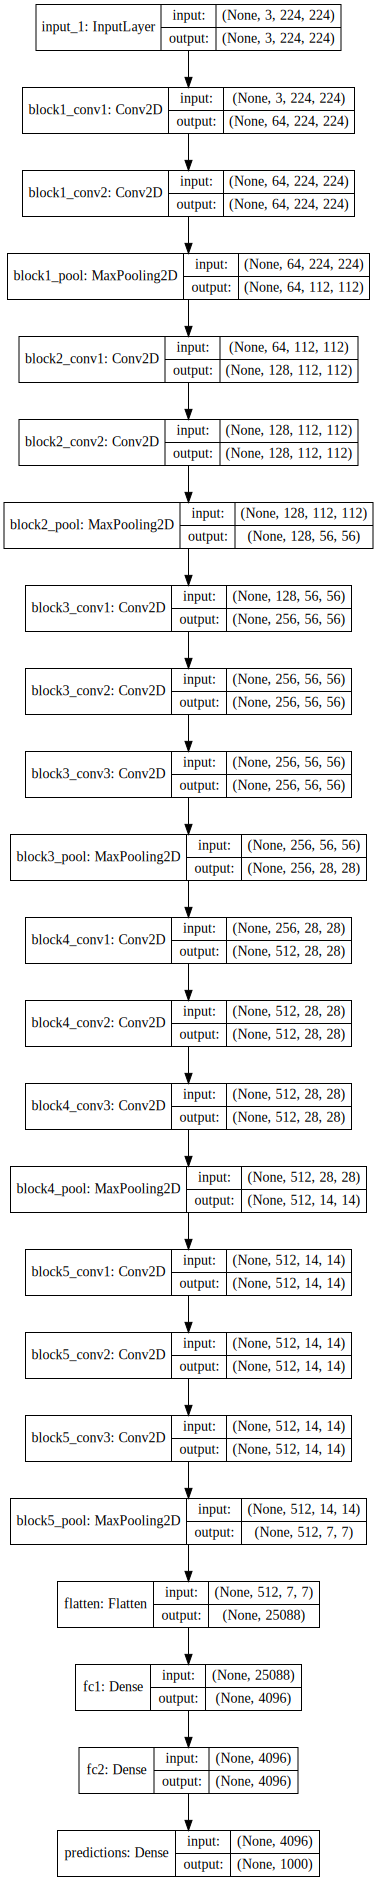

In [17]:
SVG(model_to_dot(vgg16,show_shapes=True).create(prog='dot',format='svg'))

###  Let's try to leverage transfer learning.. 
 will freeze all convolultional layer, but will try to refine dense layer

In [11]:
# Freeze all layers for now.. 
for layer in vgg16.layers:
    layer.trainable = False

In [12]:
# grab output directly after last conv layer
convs = vgg16.get_layer('flatten').output


In [13]:

#create new layers
new = Dense(4096, activation='relu', name='fc6_pose')(convs)
new = Dense(4096, activation='relu', name='fc7_pose')(new)

# predict locations

# output : 2 visibility probabilities
vis1 = Dense(2, activation='softmax', name='visibility1')(new)
vis2 = Dense(2, activation='softmax', name='visibility2')(new)
vis3 = Dense(2, activation='softmax', name='visibility3')(new)
vis4 = Dense(2, activation='softmax', name='visibility4')(new)
vis5 = Dense(2, activation='softmax', name='visibility5')(new)
vis6 = Dense(2, activation='softmax', name='visibility6')(new)

# landmark outputs
lm=Dense(12,activation='linear',name='landmarks')(new)

outputs=[vis1, vis2, vis3, vis4,vis5, vis6, lm]

model = Model(input=vgg16.input, output=outputs)
#model.summary()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`


#### Blue Branch Losses
- Regression loss for landmark localization & softmax for visibility
 - a) Modified L2 regression loss is ussed to localize landmarks
   dot(vj,(lj_hat-lj)**2

In [54]:
from keras.preprocessing import image
import keras.backend as K

train_gen= keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0.,
    width_shift_range=0.,
    height_shift_range=0.,
    shear_range=0.,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None)

In [56]:
# limiting batch size to 16 ~ due to GPU mem issues
train_generator = train_gen.flow_from_directory(
        '/home/ubuntu/upper/make_train',
        target_size=(224, 224),
        batch_size=8,
        class_mode='sparse')

Found 21488 images belonging to 1 classes.


In [55]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        '/home/ubuntu/upper/make_test',
        target_size=(224, 224),
        batch_size=8,
        class_mode='sparse')


Found 5228 images belonging to 1 classes.


#### Get All the Labels, 
Feed into model as numpy arrays

In [ ]:
train_generator.filenames

In [23]:

## Training & Test : get binary labels for visibility 

def get_labels(labels,generator):
    # ex: all filenames of train_generator
    get_list=generator.filenames
    labs=labels.loc[get_list]
    labs=labs.as_matrix()
    labs=np_utils.to_categorical(labs)
    return labs
    

# get all labels for occlusion
train_lab_1=get_labels(Y1,train_generator)
test_lab_1=get_labels(Y1,test_generator)

train_lab_2=get_labels(Y2,train_generator)
test_lab_2=get_labels(Y2,test_generator)

train_lab_3=get_labels(Y3,train_generator)
test_lab_3=get_labels(Y3,test_generator)

train_lab_4=get_labels(Y4,train_generator)
test_lab_4=get_labels(Y4,test_generator)

train_lab_5=get_labels(Y5,train_generator)
test_lab_5=get_labels(Y5,test_generator)

train_lab_6=get_labels(Y6,train_generator)
test_lab_6=get_labels(Y6,test_generator)


In [24]:
## get landmark labels 

landmarks=train_index[['lms']]

def get_labels_lm(labels,generator):
    # ex: all filenames of train_generator
    get_list=generator.filenames
    labs=labels.loc[get_list]
    return np.array(list(labs))

lm_train_labels=get_labels_lm(train_index.lms,train_generator)
lm_test_labels=get_labels_lm(train_index.lms,test_generator)
#lm_train_labels[:5]

In [57]:
21488/8

2686.0

In [58]:
# now we have 21488
def train_flow_from_directory(flow_from_directory_gen, list_of_values1,list_of_values2,list_of_values3,list_of_values4,\
                              list_of_values5,list_of_values6,list_of_values7):
    # create infinite loop for labels, 
        
    for i,x in enumerate(flow_from_directory_gen):
        i = i%2686
        # control for half of a batch
        length=len(x[0])
        yield(x[0],[list_of_values1[i*8:i*8+length],list_of_values2[i*8:i*8+length],\
                    list_of_values3[i*8:i*8+length],list_of_values4[i*8:i*8+length],\
                    list_of_values5[i*8:i*8+length],list_of_values6[i*8:i*8+length],
                   list_of_values7[i*8:i*8+length]])

In [59]:
# now we have 5228
def test_flow_from_directory(flow_from_directory_gen, list_of_values1,list_of_values2,list_of_values3,list_of_values4,
                             list_of_values5,list_of_values6,list_of_values7):
    # create infinite loop for labels, 
        
    for i,x in enumerate(flow_from_directory_gen):
        i = i%326
        # control for half of a batch
        length=len(x[0])
        # outputs need to be in a list! 
        yield(x[0],[list_of_values1[i*8:i*8+length],list_of_values2[i*8:i*8+length],\
                    list_of_values3[i*8:i*8+length],list_of_values4[i*8:i*8+length],\
                    list_of_values5[i*8:i*8+length],list_of_values6[i*8:i*8+length],
                   list_of_values7[i*8:i*8+length]])
            
#regression_flow_from_directory(train_generator, list_in_order)

##### See Backward Pass & Losses
backward pass: back-propagates the errors of four kinds of loss functions iteratively, 
A modified L2 regression loss is used to localize landmarks 
L = (summation)||vj*(actual-predicted)||^2
vj~ vector of predicted landmarks

In landmark visibility state, "0" represents visible;

In [49]:
a=[[.25,.75],[.75,.25]]
b=np.argmax(a,axis=-1)
np.dot(b,a)
b

array([1, 0])

In [50]:
# sweet: Keras will automatically read in predictions; 


def custom_objective(y_true, y_pred):
    '''tailored cost function'''
    
    #get landmarks

    pred_lm=y_pred[6]
    true_lm=y_true[6]
    
    pred_lm=K.reshape(pred_lm,(6,2))
    true_lm=K.reshape(true_lm,(6,2))
    
    
    
    # get visibility binaries
    true_viz=y_true[:6]
    
    # predict if visible or not, if not visible, set landmark loss to zero
    wins=K.argmax(true_viz,axis=1)
    wins=K.cast(wins,dtype='float32')
    wins=K.reshape(wins,(1,6))
    
    # cast these, just to be sure!
    #wins=K.cast_to_floatx(wins)
    
    #shapes : wins: (1,6), pred_lm: 6,2
    loss=K.mean(K.square(K.dot(wins,(pred_lm-true_lm))))  # 
    
    
    
    return loss

In [28]:
def custom_metric(y_true, y_pred):
    return K.mean(K.square(y_true-y_pred))



In [29]:
from keras import backend as K

def single_class_accuracy(interesting_class_id):
    def fn(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_preds = K.argmax(y_pred, axis=-1)
        # Replace class_id_preds with class_id_true for recall here
        accuracy_mask = K.cast(K.equal(class_id_preds, interesting_class_id), 'int32')
        class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
        class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
        return class_acc
    return fn

In [30]:
#model=keras.models.load_model('weights.03-557.26.hdf5')

In [60]:
# metrics : used to judge the performance (but classifier only makes changes based on )

from keras.optimizers import SGD, Adam

#losses=['sparse_categorical_crossentropy','sparse_categorical_crossentropy','sparse_categorical_crossentropy','sparse_categorical_crossentropy',custom_objective]

losses=['binary_crossentropy','binary_crossentropy','binary_crossentropy','binary_crossentropy','binary_crossentropy',
'binary_crossentropy', custom_objective]
my_metrics=[single_class_accuracy(0)]
#my_metrics=['accuracy','accuracy','accuracy','accuracy',custom_metric]


#sgd = SGD( lr = 0.01, decay=1e-6, momentum=0.9, nesterov=True,clipnorm=1.0)
adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# try adding clipnorm, and clipvalue -- because gradients are going thru da roof

model.compile(loss=losses,optimizer=adam,metrics=my_metrics)

#metrics=my_metrics

In [ ]:
keras.__version__

In [61]:
## 8907, 1735

filepath='weights.{epoch:02d}-{val_loss:.2f}.hdf5'
mcp=keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)


callback=[mcp]
test=model.fit_generator(train_flow_from_directory(train_generator, train_lab_1,train_lab_2,train_lab_3,train_lab_4,train_lab_5,train_lab_6, lm_train_labels),\
                         validation_data=test_flow_from_directory(test_generator, test_lab_1,test_lab_2,test_lab_3,test_lab_4,test_lab_5,test_lab_6,\
                                                                  lm_test_labels),
                         nb_epoch=20,samples_per_epoch=50000, nb_val_samples=15000,callbacks=callback)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., steps_per_epoch=50000, epochs=20, callbacks=[<keras.ca..., validation_steps=15000)`
  if __name__ == '__main__':


Epoch 1/20


ResourceExhaustedError: OOM when allocating tensor with shape[4096,4096]
	 [[Node: Variable_38/Assign = Assign[T=DT_FLOAT, _class=["loc:@Variable_38"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable_38, Const_306)]]

Caused by op u'Variable_38/Assign', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-61-43d54d9e9652>", line 9, in <module>
    nb_epoch=20,samples_per_epoch=50000, nb_val_samples=15000,callbacks=callback)
  File "/usr/local/lib/python2.7/dist-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/training.py", line 1725, in fit_generator
    self._make_train_function()
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/training.py", line 937, in _make_train_function
    self.total_loss)
  File "/usr/local/lib/python2.7/dist-packages/keras/optimizers.py", line 415, in get_updates
    ms = [K.zeros(K.get_variable_shape(p), dtype=K.dtype(p)) for p in params]
  File "/usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py", line 603, in zeros
    dtype, name)
  File "/usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py", line 321, in variable
    v = tf.Variable(value, dtype=_convert_string_dtype(dtype), name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variables.py", line 199, in __init__
    expected_shape=expected_shape)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variables.py", line 320, in _init_from_args
    validate_shape=validate_shape).op
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/state_ops.py", line 274, in assign
    validate_shape=validate_shape)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_state_ops.py", line 43, in assign
    use_locking=use_locking, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[4096,4096]
	 [[Node: Variable_38/Assign = Assign[T=DT_FLOAT, _class=["loc:@Variable_38"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable_38, Const_306)]]


In [ ]:
# We have subset on clothes_type: upper (collars, and sleeves)

test=train_index[(train_index.landmark_visibility_3==0)&(train_index.landmark_visibility_4==0)]
test.head(3)

In [ ]:
from scipy import ndimage
base='/home/icarus/mount_data/'

img=ndimage.imread(base+'img/Sheer_Pleated-Front_Blouse/img_00000002.jpg')
plt.imshow(img)
plt.show()

In [ ]:
## ISSUES: 

#  keras returning loss ~ nan , 

# solved it by changing the floatx value in ~/.keras/keras.json from float32 to float64. (tested on GPU)
# running slower, but now getting Loss values returned
